# arxiv-exploration

Exploring the arXiv paper dataset to understand the data structure and quality before training embeddings for downstream applications.


## Setup

This notebook is designed to work in both Google Colab and local environments.

**For Google Colab:**
- **Mount Google Drive:** Enables saving files and accessing them across Colab
    > ⚠ **Warning** <br>
    > This mounts your entire Google Drive, giving theoretical access to all files. While the code only accesses the project folder, consider using a dedicated Google account.
- **Clone the repository:** Ensures the latest code and utility modules are available.
- Add repo to Python path: Lets us import custom project modules as regular Python packages.

**For local environments:**
- Add project root to Python path: Lets us import custom project modules from the parent directory.

[ Optionally ]:
- Enable Autoreload: Lets us modify utility modules without having to reload them manually (useful for development).

In [1]:
import os
import sys

def setup_environment(repo_url, dev=False, drive_mount_path="/content/drive"):
    """Sets up the development environment for both Google Colab and local environments."""

    if "google.colab" not in sys.modules:
        # Define local project root
        project_root = os.path.dirname(os.getcwd())

        print("Not running in Google Colab.\nSkipping Colab setup.")

    else:
        # Mount Google Drive
        from google.colab import drive
        drive.mount(drive_mount_path, force_remount=True)

        # Define where within Drive to clone the git repository
        project_parent_dir = os.path.join(drive_mount_path, "MyDrive")
        project_name = repo_url.split("/")[-1].replace('.git', "")
        project_root = os.path.join(project_parent_dir, project_name)

        # Clone the repository if it doesn't exist
        if not os.path.exists(project_root):
            print(f"\nCloning repository into {project_root}")
            try:
                os.chdir(project_parent_dir)  # Change to the parent directory to clone the repo
                !git clone {repo_url}
            finally:
                os.chdir(project_root)  # Always change back to the original directory, even if clone fails
        else:
            print(f"\nRepository already exists at {project_root}")

        print("\nColab setup complete.")

    # Add project to Python path
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
        print(f"\n'{project_root}' added to Python path.")
    else:
        print(f"\n'{project_root}' in Python path.")

    # Enable autoreload (for developement)
    if dev:
        from IPython import get_ipython
        ipython = get_ipython()

        # Load extension quietly if not already loaded
        if "autoreload" not in ipython.extension_manager.loaded:
            ipython.magic("load_ext autoreload")

        print("\nAutoreload extension enabled (mode 2).")
        ipython.magic("autoreload 2")

In [2]:
setup_environment("https://github.com/nadrajak/arxiv-semantic-search.git", dev=True)

Mounted at /content/drive

Repository already exists at /content/drive/MyDrive/arxiv-semantic-search

Colab setup complete.

'/content/drive/MyDrive/arxiv-semantic-search' added to Python path.

Autoreload extension enabled (mode 2).


## Imports

In [3]:
import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt

# Custom modules
from utils import config
from utils import data_loader
from utils import preprocessing

In [4]:
np.random.seed(config.RANDOM_SEED);

config.setup_plot_style()

## Load data

We use the [arXiv dataset from Kaggle](https://www.kaggle.com/Cornell-University/arxiv), which contains metadata and abstracts for scholarly papers across STEM fields.

Below, we load a sample of 100,000 papers for exploration.


In [5]:
# Download dataset from Kaggle
arxiv_dataset_path = data_loader.load_arxiv_dataset()

In [6]:
# Load json file as a pandas DataFrame
data = pd.read_json(arxiv_dataset_path, lines=True, nrows=100_000)

print("Dataset shape:", data.shape)

Dataset shape: (100000, 14)


## Initial exploration

First, we inspect the dataset structure, data types, and a sample of the data to verify that it contains all necessary features.

In [7]:
# Display basic information about the DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              100000 non-null  float64
 1   submitter       100000 non-null  object 
 2   authors         100000 non-null  object 
 3   title           100000 non-null  object 
 4   comments        87343 non-null   object 
 5   journal-ref     50768 non-null   object 
 6   doi             61392 non-null   object 
 7   report-no       9466 non-null    object 
 8   categories      100000 non-null  object 
 9   license         56778 non-null   object 
 10  abstract        100000 non-null  object 
 11  versions        100000 non-null  object 
 12  update_date     100000 non-null  object 
 13  authors_parsed  100000 non-null  object 
dtypes: float64(1), object(13)
memory usage: 10.7+ MB
None


The first 100,000-paper sample contains 14 features, including authors, title, categories, and abstract. These features are sufficient for embedding training and downstream tasks and they cointain no missing values.

Below, we view a few sample rows and examine how are the papers sorted.

In [8]:
data.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [9]:
# Show the detailed versions of the first papers
for versions in data.iloc[:5]["versions"]:
    print(versions)

# Check arXiv ids
print(f"\nMinimum id: {min(data['id'])}")
print(f"Maximum id: {max(data['id'])}\n")

# Check dates
dates = [datetime.strptime(versions[0]["created"], "%a, %d %b %Y %H:%M:%S GMT") for versions in data['versions']]
print(f"Minimum date: {min(dates)}")
print(f"Maximum date: {max(dates)}")

[{'version': 'v1', 'created': 'Mon, 2 Apr 2007 19:18:42 GMT'}, {'version': 'v2', 'created': 'Tue, 24 Jul 2007 20:10:27 GMT'}]
[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 02:26:18 GMT'}, {'version': 'v2', 'created': 'Sat, 13 Dec 2008 17:26:00 GMT'}]
[{'version': 'v1', 'created': 'Sun, 1 Apr 2007 20:46:54 GMT'}, {'version': 'v2', 'created': 'Sat, 8 Dec 2007 23:47:24 GMT'}, {'version': 'v3', 'created': 'Sun, 13 Jan 2008 00:36:28 GMT'}]
[{'version': 'v1', 'created': 'Sat, 31 Mar 2007 03:16:14 GMT'}]
[{'version': 'v1', 'created': 'Mon, 2 Apr 2007 18:09:58 GMT'}]

Minimum id: 704.0001
Maximum id: 812.3873

Minimum date: 2007-03-31 02:26:18
Maximum date: 2008-12-19 20:54:21


**Summary**:
- No missing values in key columns: authors, title, abstract, and categories.
- The `authors` column:
    - Has inconsistent name formatting (e.g., initials).
    - Contain LaTeX special characters; the `authors_parsed` field helps clean these, though formatting is lost.
- The `title` and `categories` columns contain LaTeX math and may contain LaTeX special character as well.
- Multiple and hierarchical categories are present for some papers.
- Papers appear sorted by creation date (`id` and `versions`).
    - arXiv IDs are expected in `YYMM.number` format, but pre-2010 entries may lack leading zeros.  
    - The earliest IDs are from April 2007, but the minimum creation date is March 2007. Likely due to the new ID scheme rollout in April 2007 ([see arXiv docs](https://info.arxiv.org/help/arxiv_identifier.html)).

## Abstract exploration

Since abstracts are our primary training data, we analyze their quality and content below.

In [10]:
# Check the contents of a sample abstract
print(f"\'{data.iloc[1]['abstract']}\'")

'  We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use
it obtain a characterization of the family of $(k,\ell)$-sparse graphs and
algorithmic solutions to a family of problems concerning tree decompositions of
graphs. Special instances of sparse graphs appear in rigidity theory and have
received increased attention in recent years. In particular, our colored
pebbles generalize and strengthen the previous results of Lee and Streinu and
give a new proof of the Tutte-Nash-Williams characterization of arboricity. We
also present a new decomposition that certifies sparsity based on the
$(k,\ell)$-pebble game with colors. Our work also exposes connections between
pebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and
Westermann and Hendrickson.
'


Abstracts sometimes contain irregular whitespace and LaTeX math expressions, which can impact tokenization. We clean and normalize whitespace as a first step.

We leave the LaTeX math as is for now.

In [11]:
# Remove redundant whitespace characters
data = preprocessing.normalize_whitespace(data)
print(f"\'{data.iloc[1]['abstract']}\'")

'We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use it obtain a characterization of the family of $(k,\ell)$-sparse graphs and algorithmic solutions to a family of problems concerning tree decompositions of graphs. Special instances of sparse graphs appear in rigidity theory and have received increased attention in recent years. In particular, our colored pebbles generalize and strengthen the previous results of Lee and Streinu and give a new proof of the Tutte-Nash-Williams characterization of arboricity. We also present a new decomposition that certifies sparsity based on the $(k,\ell)$-pebble game with colors. Our work also exposes connections between pebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and Westermann and Hendrickson.'


We know there are no missing abstracts, but we need to confirm that all entries are non-empty and of reasonable quality.

Below, we visualize the distribution of abstract lengths (in characters and words) to understand their variability and identify any outliers.

In [12]:
# Calculate character and word counts for abstracts
data["abstract_char_count"] = data["abstract"].str.len()
data["abstract_word_count"] = data["abstract"].str.split().str.len()

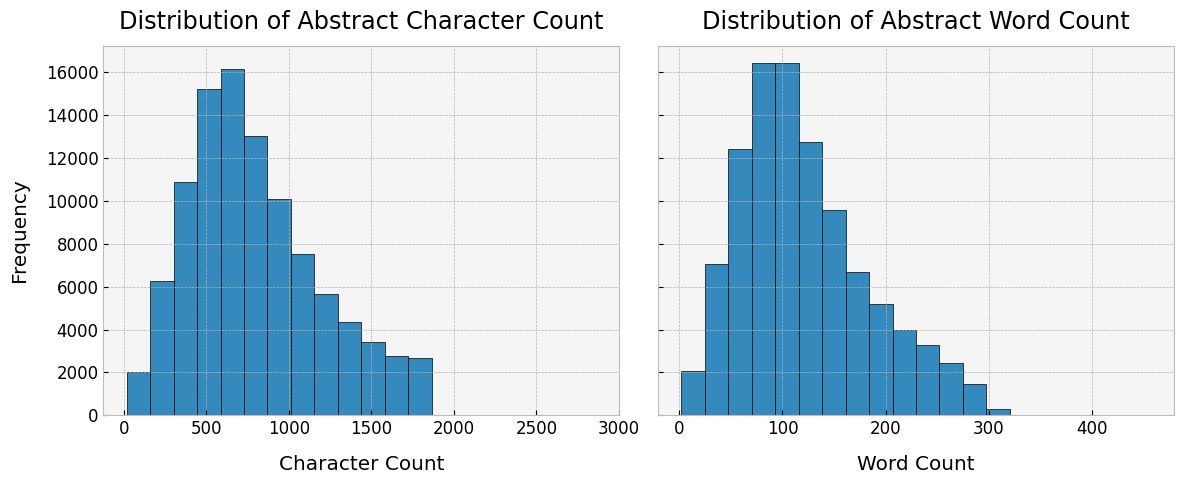

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes[0].hist(data["abstract_char_count"], bins=20, edgecolor="black")
axes[0].set_title("Distribution of Abstract Character Count")
axes[0].set_xlabel("Character Count")
axes[0].set_ylabel("Frequency")

axes[1].hist(data["abstract_word_count"], bins=20, edgecolor="black")
axes[1].set_title("Distribution of Abstract Word Count")
axes[1].set_xlabel("Word Count")

plt.tight_layout()

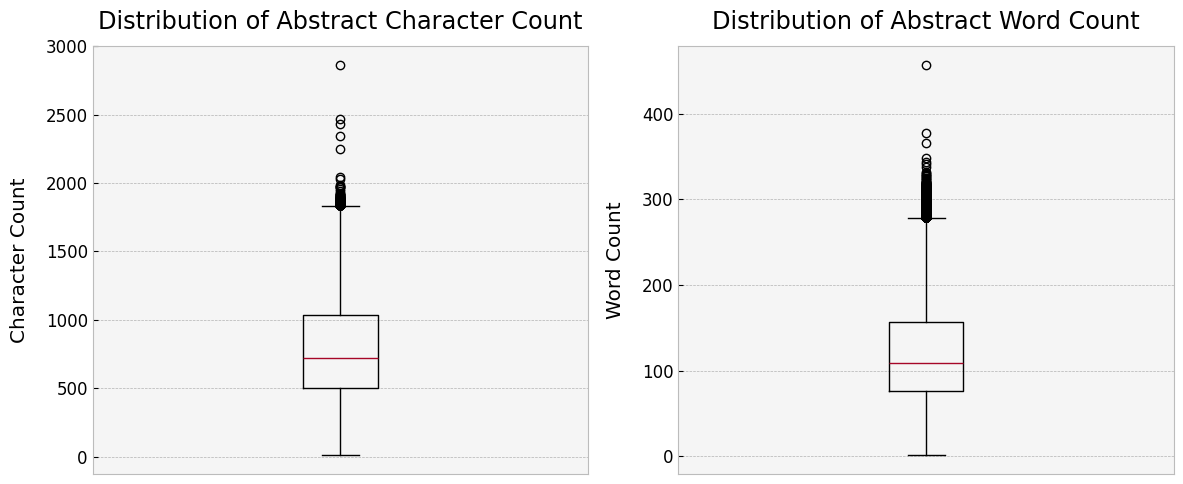

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].boxplot(data["abstract_char_count"])
axes[0].set_title("Distribution of Abstract Character Count")
axes[0].set_ylabel("Character Count")
axes[0].set_xticks([])

axes[1].boxplot(data["abstract_word_count"])
axes[1].set_title("Distribution of Abstract Word Count")
axes[1].set_ylabel("Word Count")
axes[1].set_xticks([])

plt.tight_layout()

In [15]:
print(f"Abstract Word Count - 5th Quantile: {int(data['abstract_word_count'].quantile(0.05))}")
print(f"Abstract Word Count - 95th Quantile: {int(data['abstract_word_count'].quantile(0.95))}")

Abstract Word Count - 5th Quantile: 36
Abstract Word Count - 95th Quantile: 247


In [16]:
for abstract in data[data["abstract_word_count"] < 30]["abstract"].sample(10):
    print(f"\'{abstract}\'\n")

'This paper has been withdrawn.'

'In this paper, we review Shirshov's method for free Lie algebras invented by him in 1962 which is now called the Groebner-Shirshov bases theory.'

'In this paper, we prove the nonlinear orbital stability of the stationary traveling wave of the one-dimensional Gross-Pitaevskii equation by using Zakharov-Shabat's inverse scattering method.'

'We prove asymptotic estimates for the cross-ratio distortion with respect to a smooth or holomorphic function in terms of its Schwarz derivative.'

'We study the Grassmannian 4-designs contained in lattices, in connection with the local property of the Rankin constant. We prove that the sequence of Barnes-Wall lattices contain Grassmannian 6-designs.'

'This paper surveys some selected topics in the theory of conformal metrics and their connections to complex analysis, partial differential equations and conformal differential geometry.'

'Rewriting a shorter abstract.'

'The class J of simultaneously almost transit

The word count of abstracts ranges from 2 to 457, with the 5th and 95th percentiles at 36 and 247 words, respectively.

To ensure quality, we will retain only abstracts with 30 to 300 words. Shorter abstracts may indicate withdrawn papers, supplements, or missing content.

In [17]:
data = preprocessing.normalize_abstracts(data)

print(data["abstract_word_count"].describe())

count    96639.000000
mean       123.751011
std         60.067920
min         30.000000
25%         79.000000
50%        111.000000
75%        159.000000
max        300.000000
Name: abstract_word_count, dtype: float64


### Category exploration

Next, we analyze the category distributions, noting that many papers have multiple and hierarchical categories (e.g., `'cs.AI'`, `'stat.ML'`), which can create sparsity and visualization challenges.

In [18]:
# Category distribution (before truncation)
full_categories = data["categories"].str.split(' ').explode()

print(f"Unique categories ({full_categories.nunique()}):\n")
print(np.sort(full_categories.unique()))

Unique categories (149):

['astro-ph' 'astro-ph.CO' 'astro-ph.EP' 'astro-ph.GA' 'astro-ph.HE'
 'astro-ph.IM' 'astro-ph.SR' 'cond-mat.dis-nn' 'cond-mat.mes-hall'
 'cond-mat.mtrl-sci' 'cond-mat.other' 'cond-mat.quant-gas' 'cond-mat.soft'
 'cond-mat.stat-mech' 'cond-mat.str-el' 'cond-mat.supr-con' 'cs.AI'
 'cs.AR' 'cs.CC' 'cs.CE' 'cs.CG' 'cs.CL' 'cs.CR' 'cs.CV' 'cs.CY' 'cs.DB'
 'cs.DC' 'cs.DL' 'cs.DM' 'cs.DS' 'cs.ET' 'cs.FL' 'cs.GL' 'cs.GR' 'cs.GT'
 'cs.HC' 'cs.IR' 'cs.IT' 'cs.LG' 'cs.LO' 'cs.MA' 'cs.MM' 'cs.MS' 'cs.NA'
 'cs.NE' 'cs.NI' 'cs.OH' 'cs.OS' 'cs.PF' 'cs.PL' 'cs.RO' 'cs.SC' 'cs.SD'
 'cs.SE' 'cs.SI' 'cs.SY' 'econ.EM' 'econ.TH' 'gr-qc' 'hep-ex' 'hep-lat'
 'hep-ph' 'hep-th' 'math-ph' 'math.AC' 'math.AG' 'math.AP' 'math.AT'
 'math.CA' 'math.CO' 'math.CT' 'math.CV' 'math.DG' 'math.DS' 'math.FA'
 'math.GM' 'math.GN' 'math.GR' 'math.GT' 'math.HO' 'math.IT' 'math.KT'
 'math.LO' 'math.MG' 'math.MP' 'math.NA' 'math.NT' 'math.OA' 'math.OC'
 'math.PR' 'math.QA' 'math.RA' 'math.RT' 'math.SG'

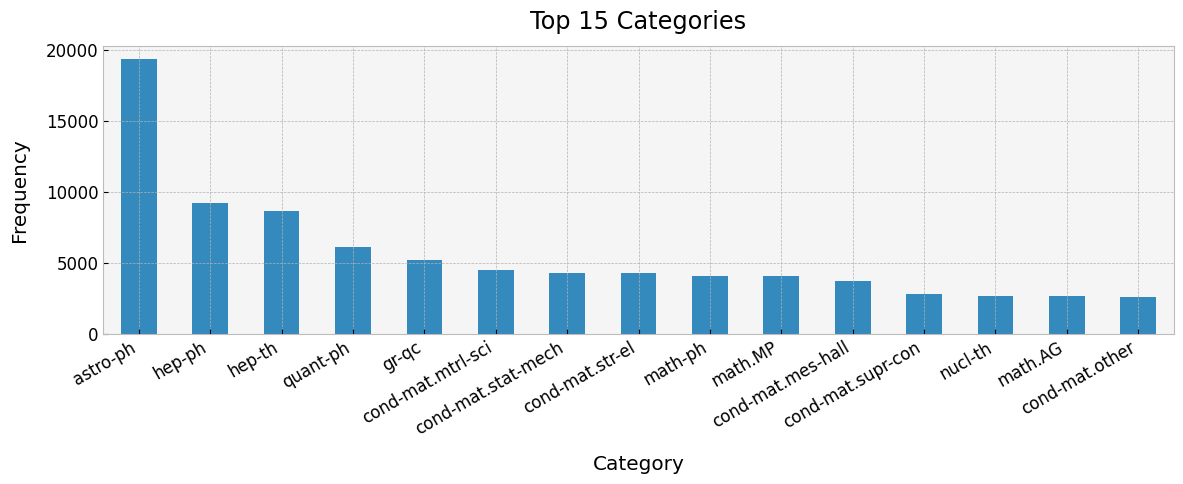

In [19]:
plt.figure(figsize=(12, 5))

full_categories.value_counts().head(15).plot(kind='bar')
plt.title('Top 15 Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=30, ha='right')

plt.tight_layout()

**Category truncation:**
- Use only the primary category (first listed) per paper
- Truncate to main category only (e.g., `'cs.AI'` → `'cs'`)
- Merge categories that span multiple main categories  (e.g., `'nucl-th'`, `'nucl-ex'` → `'nucl'`)

This reduces category space while maintaining meaningful field groupings.

In [20]:
# Category distribution after truncation
data = preprocessing.truncate_categories(data)

print(f"Unique categories ({data['category'].nunique()}):\n")
print(np.sort(data['category'].unique()))

Unique categories (13):

['astro-ph' 'cond-mat' 'cs' 'gr-qc' 'hep' 'math' 'nlin' 'nucl' 'physics'
 'q-bio' 'q-fin' 'quant-ph' 'stat']


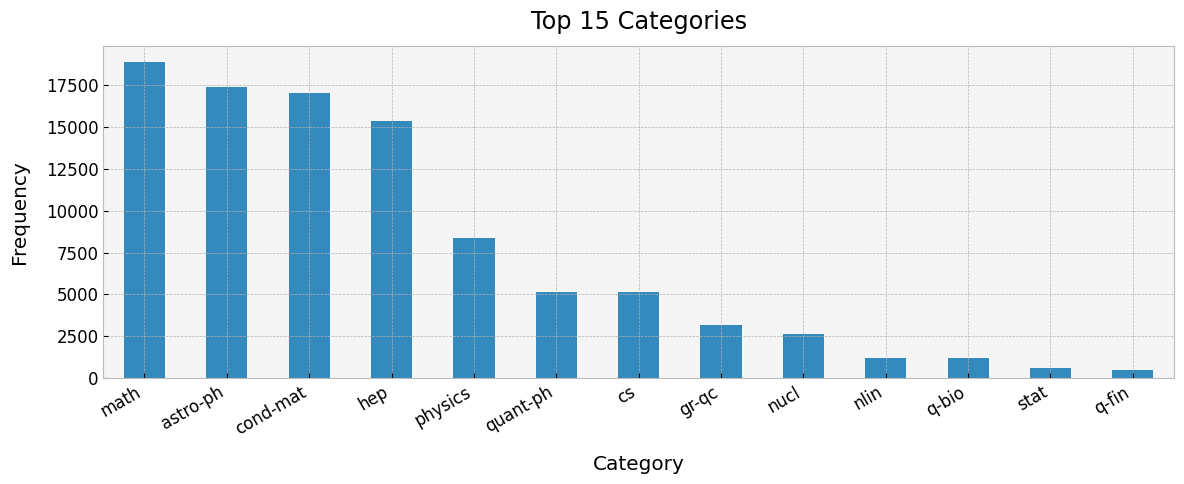

In [21]:
plt.figure(figsize=(12, 5))

data['category'].value_counts().head(15).plot(kind='bar')
plt.title('Top 15 Categories')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=30, ha='right')

plt.tight_layout()

## Final data preparation

Our preprocessing pipeline focuses on essential steps:
- **Column selection** - Keep only necessary features
- **Whitespace normalization** - Clean irregular spacing in all text columns
- **Length filtering** - Ensure abstract quality
- **Category truncation** - Simplify category structure

Below, we display a sample paper's main fields.

In [22]:
# Keep only essential columns for our use case
data = data[["title", "abstract", "category", "authors"]]
data.head(5)

,title,abstract,category,authors
0,Calculation of prompt diphoton production cros...,A fully differential calculation in perturbati...,hep,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-..."
1,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-pe...",math,Ileana Streinu and Louis Theran
2,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is describe...,physics,Hongjun Pan
3,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle n...,math,David Callan
4,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\Lam...,math,Wael Abu-Shammala and Alberto Torchinsky


In [23]:
sample_paper = data.iloc[1]
print(f"'{sample_paper['title']}'")
print(f"\n'{sample_paper['abstract']}'")
print(f"\n'{sample_paper['category']}'")
print(f"\n'{sample_paper['authors']}'")

'Sparsity-certifying Graph Decompositions'

'We describe a new algorithm, the $(k,\ell)$-pebble game with colors, and use it obtain a characterization of the family of $(k,\ell)$-sparse graphs and algorithmic solutions to a family of problems concerning tree decompositions of graphs. Special instances of sparse graphs appear in rigidity theory and have received increased attention in recent years. In particular, our colored pebbles generalize and strengthen the previous results of Lee and Streinu and give a new proof of the Tutte-Nash-Williams characterization of arboricity. We also present a new decomposition that certifies sparsity based on the $(k,\ell)$-pebble game with colors. Our work also exposes connections between pebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and Westermann and Hendrickson.'

'math'

'Ileana Streinu and Louis Theran'
